In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from scipy.special import gamma
import scipy

In [2]:
data = np.load('..\data.npy')
data.shape

(10000,)

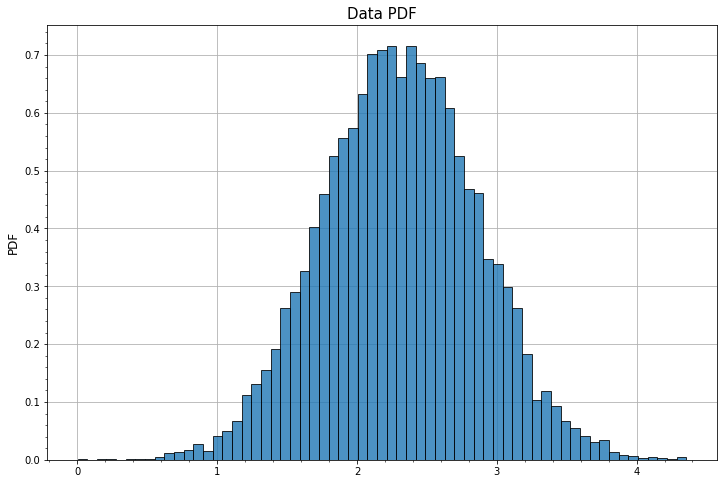

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.hist(data, bins='fd', density=True, alpha = 0.8, edgecolor='black', zorder = 2)
ax.grid(zorder = 1)
ax.minorticks_on()
ax.set_title('Data PDF', fontsize = 15)
ax.set_ylabel('PDF', fontsize = 12)
plt.show()

### Priors

In [4]:
def gaussian(x,mu=4,std=2):
    '''I have altready put the default values of alpha and beta'''

    prior = scipy.stats.norm.pdf(x, loc=mu, scale=std)

    return prior

def inverse_gamma(x,alpha=2,beta=1):
    '''I have altready put the default values of alpha and beta'''

    f = (beta**alpha / gamma(alpha)) * (1/x)**(alpha + 1) * np.exp(-beta/x)
    return f

## Metripolis Algorithm

In [5]:
def log_likelihood(x, mu, sigma):
    #return np.sum(np.log( (1/(np.sqrt(2*np.pi*sigma**2))) * np.exp(-((x-mu)**2)/(2*sigma**2)) ) )
    
    likelihood = scipy.stats.norm.pdf(x, loc=mu, scale=sigma)
    return np.sum(np.log(likelihood))

def prior_mu(mu, m , s):
    #return ((1/(np.sqrt(2*np.pi*s**2))) * np.exp(-((x-m)**2)/(2*s**2)))
    
    prior = scipy.stats.norm.pdf(mu, loc=m, scale=s)
    return prior

def prior_sigma(x, alpha, beta):
    prior = (beta**(alpha) / scipy.special.gamma(alpha)) * (1 / x**(alpha + 1)) * np.exp(-beta / x) 
    return prior

### Try something more

In [6]:
import plotly.figure_factory as ff
import plotly.express as px
from ipywidgets import VBox, HBox, Output, Button, IntText, Label, FloatText

import matplotlib.pyplot as plt
from matplotlib.transforms import Affine2D
from matplotlib.collections import PathCollection
import matplotlib.animation as animation

In [12]:
def run_mcmc(caller):
    out.clear_output()
    display_label.value = "Runnin MCMC"

    burnin = burin_input.value  # number of burn-in iterations
    # lag = lag_input.value  # iterations between successive samples
    nsamp = nsamp_input.value # number of samples to draw
    mu = mu_start_input.value # start point
    sigma = sigma_start_input.value # start point
    tau = autocorr_time_input.value
   
    # nsamp = 1000; mu0=2; sigma0=1
   
    Mu = np.zeros((nsamp,1)) 
    Sigma = np.zeros((nsamp,1)) # samples drawn from the Markov chain
    # acc = np.array((0, 0))  # vector to track the acceptance rate
    acc = 0  # vector to track the acceptance rate
    
    # def log_likelihood(x, mu, sigma):
    
    #     likelihood = scipy.stats.norm.pdf(x, loc=mu, scale=sigma)
    #     return np.sum(np.log(likelihood))

    def MHstep(data, mu0, sigma0, tau=tau):
        # cov = tau * np.identity(2) # covariance matrix of the normal ditr for the proposals
        # mu_new, sigma_new = np.random.multivariate_normal(mean=(mu0, sigma0), cov=tau**2 * np.identity(2)) #generate from 2D normal distribution
        
        mu_new = np.random.normal(loc=mu0, scale=0.1)
        sigma_new = np.random.normal(loc=sigma0, scale=0.1)
        
        # acceptance_prob = np.exp(log_posterior(data, mu_new, sigma_new) - log_posterior(data, mu0, sigma0))
        
        #posterior with the proposal values
        propos_post = log_likelihood(data, mu_new, sigma_new) + np.log(gaussian(mu_new)) + np.log(inverse_gamma(sigma_new))
        #posterior with the current values
        current_post =  log_likelihood(data, mu0, sigma0) + np.log(gaussian(mu0)) + np.log(inverse_gamma(sigma0))
    
        acceptance_prob = np.min([1 , np.exp( propos_post - current_post) ])
        
        u = np.random.rand() # uniform random number
        if u <= acceptance_prob: # if accepted
            mu = mu_new ; sigma = sigma_new # update with new values
            a = 1 # acceptance
        else: # if rejected
            mu = mu0 ; sigma = sigma0 # update with the old values
            a = 0 # rejection
        return mu, sigma, a

    # MC routine

    for i in range(burnin):
        mu, sigma, a = MHstep(data, mu, sigma)
        # acc = acc + np.array((a, 0)) # track accept-reject status
        acc = acc + a # track accept-reject status

    for i in range(nsamp):
        mu, sigma, a = MHstep(data, mu, sigma)
        # acc = acc + np.array((a, 1)) # track accept-reject status
        acc = acc + a # track accept-reject status

        Mu[i] = mu; 
        Sigma[i] = sigma

    df = pd.DataFrame.from_dict({'mu':[Mu], 'sigma':[Sigma]})
    

    # display_label.value = 'Average Acceptance: ' + str(round(acc[0] / acc[1],2)) + ';   ' + 'Mean_mu=' + str(round(np.mean(Mu), 3)) +';   ' +'Mean_sigma=' + str(round(np.mean(Sigma), 3))
    
    display_label.value = 'Avg Accept: ' + str(round(acc/nsamp, 3)) + ';   ' + 'Mean_mu=' + str(round(np.mean(Mu), 4)) +';   ' +'Mean_sigma=' + str(round(np.mean(Sigma), 4))
    

    with out:
        fig, axs = plt.subplots(2, 2, figsize=(20,20))

        # axs[0,0].hist(df['mu'].values, bins=int(np.sqrt(len(Mu))))
        axs[0,0].hist(df['mu'].values, bins='fd')
        axs[0,1].plot(df['mu'].squeeze())

        # axs[1,0].hist(df['sigma'].values, bins=int(np.sqrt(len(Mu))))
        axs[1,0].hist(df['sigma'].values, bins='fd')
        axs[1,1].plot(df['sigma'].squeeze())

        r = Affine2D().rotate_deg(90)

        fig = plt.gcf()
        fig.set_size_inches(10, 10)

        plt.show()


    print(str(round(np.mean(Mu), 3)), str(round(np.mean(Sigma), 3)))        


In [13]:
%matplotlib inline
run_button = Button(description = 'Run MCMC')
burin_input = IntText(value=0, description = 'Burn-in')
nsamp_input = IntText(value=1000, description ='Num Samples')
mu_start_input = FloatText(value='2', description ='mu Starting Value')
sigma_start_input = FloatText(value='1', description ='sigma Starting Value')
autocorr_time_input = FloatText(value='0.5', description ='Tau Starting Value')

display_label  = Label(value = 'Ready to go!')
    
out = Output()

run_button.on_click(run_mcmc)

all_widgets = HBox([VBox([HBox([run_button, display_label]) ,
                    burin_input,
                    nsamp_input,
                    mu_start_input,
                    sigma_start_input,
                    autocorr_time_input]),
                    out])

display(all_widgets)


<ipython-input-12-3fd5afd3bf36>:38: RuntimeWarning: overflow encountered in exp
  acceptance_prob = np.min([1 , np.exp( propos_post - current_post) ])


2.303 0.555
